In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score # Nueva importación necesaria

In [2]:
# 1. CARGA DE DATOS
archivo = 'db\Iniciativas_VcM_2025_03_12_2025_12_47.xlsx'
df_raw = pd.read_excel(archivo, skiprows=2)
df_raw.columns = df_raw.columns.str.strip()

# 2. LIMPIEZA
df = df_raw.dropna(subset=['Nombre de la Iniciativa VcM']).copy()

# 3. IDENTIFICACIÓN DE COLUMNAS
cols_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
if 'ID' in cols_numericas: cols_numericas.remove('ID')

cols_categoricas = [col for col in df.select_dtypes(include=['object']).columns 
                    if df[col].nunique() < 50 and df[col].nunique() > 1]

# 4. PREPARACIÓN (Imputación y Encoding)
df_modelo = df[cols_numericas + cols_categoricas].copy()
df_modelo[cols_numericas] = df_modelo[cols_numericas].fillna(0)
df_modelo[cols_categoricas] = df_modelo[cols_categoricas].fillna('Sin Información')

df_encoded = pd.get_dummies(df_modelo, columns=cols_categoricas)

<>:2: SyntaxWarning: "\I" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\I"? A raw string is also an option.
<>:2: SyntaxWarning: "\I" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\I"? A raw string is also an option.
C:\Users\pablo\AppData\Local\Temp\ipykernel_19436\3002473998.py:2: SyntaxWarning: "\I" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\I"? A raw string is also an option.
  archivo = 'db\Iniciativas_VcM_2025_03_12_2025_12_47.xlsx'


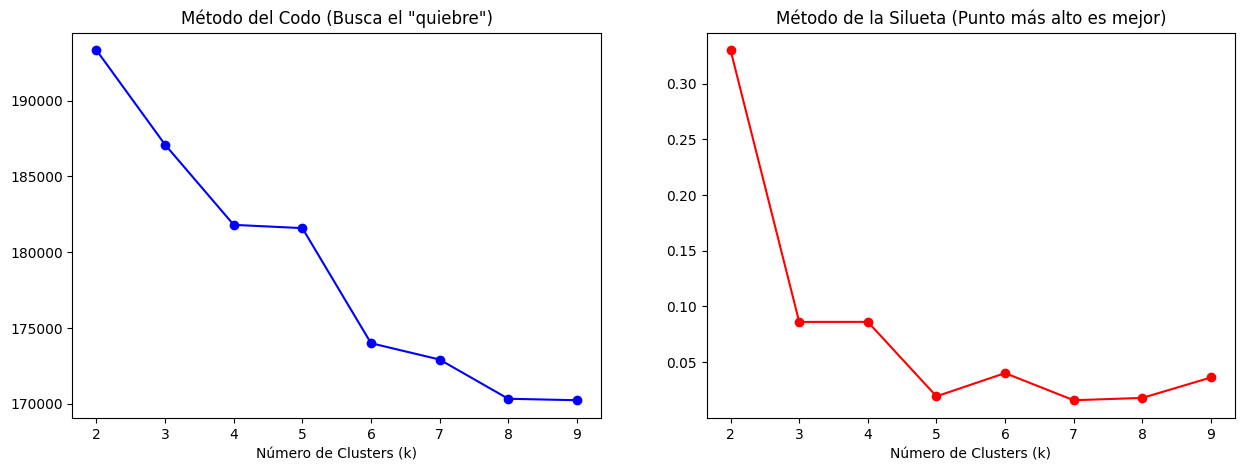

In [3]:
# ESCALAMIENTO
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# DETERMINACIÓN DE CLUSTERS
wcss = []
s_scores = []
k_range = range(2, min(10, len(df_encoded))) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    s_scores.append(silhouette_score(X_scaled, labels))

# Gráficos de validación
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(k_range, wcss, marker='o', color='blue')
ax[0].set_title('Método del Codo (Busca el "quiebre")')
ax[0].set_xlabel('Número de Clusters (k)')

ax[1].plot(k_range, s_scores, marker='o', color='red')
ax[1].set_title('Método de la Silueta (Punto más alto es mejor)')
ax[1].set_xlabel('Número de Clusters (k)')
plt.show()

In [4]:
# 1. Determinación de K (Codo y Silueta)
wcss = []
s_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    s_scores.append(silhouette_score(X_scaled, labels))

# 2. Selección automática mejorada (Punto de equilibrio)
# Si quieres forzar que no sean 2, podemos pedirle el máximo después de k=2
best_k = k_range[np.argmax(s_scores[1:]) + 1] # Ignora el k=2 para buscar más detalle

print(f"🤖 Basado en los gráficos, el mejor equilibrio es k = {best_k}")

# 3. Modelo Final
kmeans_final = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

🤖 Basado en los gráficos, el mejor equilibrio es k = 4


In [5]:
print("Distribución por Cluster:")
print(df['Cluster'].value_counts())

Distribución por Cluster:
Cluster
2    347
1    184
0     42
3     18
Name: count, dtype: int64


In [6]:
# 1. Identificar columnas dinámicamente
cols_numericas_todas = df.select_dtypes(include=[np.number]).columns.tolist()
cols_texto_todas = df.select_dtypes(include=['object']).columns.tolist()

if 'Cluster' in cols_numericas_todas: cols_numericas_todas.remove('Cluster')

# 2. Diccionario de agregación
agg_dict = {}
for col in cols_numericas_todas:
    agg_dict[col] = 'mean'
for col in cols_texto_todas:
    agg_dict[col] = lambda x: x.mode()[0] if not x.mode().empty else "N/A"

# 3. Ejecutar el agrupamiento (Quitamos el .T)
perfil_total = df.groupby('Cluster').agg(agg_dict).reset_index()

# 4. Ajustar formato para que Jupyter muestre todas las columnas sin esconderlas
import pandas as pd
pd.set_option('display.max_columns', None)  # Muestra todas las columnas a lo ancho
pd.set_option('display.expand_frame_repr', False)

print(f"--- PERFIL TOTAL POR CLUSTER (K={best_k}) ---")
display(perfil_total)

--- PERFIL TOTAL POR CLUSTER (K=4) ---


,Cluster,ID,% Avance,Monto de Financiamiento VcM Requerido,Alineación Estratégica con la Unidad de Origen,Potencial de Multidisciplina o Interdisciplina,Antigüedad de la Actividad,Diagnóstico de Necesidad o Interés,Relación con Actores Externos,Alcance de la Contribución,Generación de Conocimiento y Retroalimentación,Factibilidad Técnico-Presupuestaria,Validación Unidad de Origen (0.0%),Validación Vinculación con el Medio (100.0%),Nota final,Nombre,Primer apellido,Segundo apellido,Email,Estado,Fecha de creación,Fecha envío,Nombre Postulación,¿La iniciativa corresponde a alguna de las siguientes modalidades de Internacionalización Virtual?,Nombre de la Iniciativa VcM,Sede,Unidad o Dependencia Responsable,Escuela/Carrera Facultad de Ciencias Sociales y Artes,"Escuela/Carrera Facultad de Ciencias, Ingeniería y Tecnología",Facultad de Medicina y Ciencias de la Salud,Centro de Investigación,Otras Unidades No Académicas,Otras Unidades No Académicas.1,Programas de Postgrado,¿La iniciativa es organizada en conjunto con otras unidades académicas o administrativas?,Unidades Co-organizadoras,Otras Unidades No Académicas Co-organizadoras,Fecha de Inicio de la Iniciativa,Fecha de Término de la Iniciativa,Mecanismo VcM sugerido,Antigüedad de la Iniciativa VcM,¿La iniciativa fue ejecutada con presupuesto VcM en 2024?,"En caso afirmativo, indique el Código VcM asignado",Descripción y Acciones de la Iniciativa,¿La iniciativa está orientada a formación académica? (Vinculación Académica - VA),¿La iniciativa incluye interacción directa con actores externos?,¿La iniciativa es parte de un curso o asignatura?,Mencione el nombre de la asignatura o curso,¿La iniciativa se basa en diagnósticos o problemáticas comunitarias?,¿La actividad involucra a más de una disciplina o área de conocimiento?,¿La iniciativa implica la difusión y/o intercambio de conocimiento? (Articulación e Intercambio de Conocimiento - AIC),¿El contenido se adapta al público objetivo externo?,"¿Incluye talleres, capacitaciones o asesorías técnicas?",¿Se promueve el diálogo bidireccional con actores externos?,¿La iniciativa es una actividad cultural o artística? (Vinculación Artístico-Cultural - VAC),¿Fomenta la participación de la comunidad externa?,¿Incluye co-creación con actores externos?,¿Promueve la diversidad cultural?,"¿La iniciativa incluye investigación básica, aplicada o emprendimiento? (Investigación, Proyectos de Emprendimiento y Estudios - IPEE)",¿Participan actores externos en la formulación o implementación?,¿Se busca resolver problemáticas concretas del entorno?,¿Se generan productos o soluciones prácticas?,¿La iniciativa implica alianzas internacionales? (Internacionalización - INT),¿Incluye movilidad académica o estudiantil?,¿Se desarrollan proyectos de investigación colaborativa internacional?,¿Se promueve el intercambio cultural o académico?,"¿La iniciativa está orientada a graduados/titulados y/o empleadores? (Graduados/Titulados, Empleabilidad y Redes - GTER)",¿Incluye retroalimentación curricular con empleadores?,¿Se fomenta la empleabilidad de los graduados?,¿Se promueven redes profesionales?,¿La iniciativa responde a problemáticas identificadas con actores externos?,¿Cómo se identificaron estas problemáticas?,Modalidad de Implementación de la Iniciativa,Alcance Territorial de la Iniciativa,Tipo de Público Externo Participante,Otro Tipo de Público Externo Participante,Ámbitos Estratégicos que Aborda la Iniciativa,Objetivos de Desarrollo Sostenible (ODS) que Apoya la Iniciativa,Competencias Sello Institucionales Potenciadas por la Iniciativa,Tipo de Acceso a la Iniciativa,Requerimiento de Financiamiento VcM,Uso del Presupuesto Solicitado,"Si seleccionó ""Otro uso"", especifique el destino del presupuesto",Fuente de Financiamiento Externo,Acceso a la Iniciativa,"Si corresponde, indique el nombre de la organización o actor externo con el que ya cuente con un compromiso o acuerdo de trabajo",¿Qué objetivos espera alcanzar para la universidad con esta iniciativa?,

In [7]:
# 1. Generar el perfil base
perfil_total = df.groupby('Cluster').agg(agg_dict).reset_index()

# 2. Filtrado quirúrgico: Solo columnas donde NADA se repite entre clusters
n_clusters = len(perfil_total)
columnas_finales = []

for col in perfil_total.columns:
    if col == 'Cluster':
        columnas_finales.append(col)
        continue
    
    # Limpiamos y comparamos con redondeo para evitar falsos positivos
    if perfil_total[col].dtype in [np.float64, np.int64, np.float32]:
        valores_unicos = perfil_total[col].round(2).nunique()
    else:
        valores_unicos = perfil_total[col].astype(str).str.strip().nunique()
    
    # Solo si CADA fila tiene un dato distinto (cero repeticiones)
    if valores_unicos == n_clusters:
        columnas_finales.append(col)

# 3. Crear la tabla y obtener la lista de columnas
perfil_estricto = perfil_total[columnas_finales]
lista_nombres = perfil_estricto.columns.tolist()

# 4. IMPRESIÓN SOLICITADA: Separada por comas en una misma línea
# Filtramos 'Cluster' de la lista para mostrar solo las variables diferenciadoras
columnas_solo_datos = [c for c in lista_nombres if c != 'Cluster']

print(f"✅ Se encontraron {len(columnas_solo_datos)} columnas con datos 100% únicos.")
print("-" * 50)
print("LISTA DE COLUMNAS (Diferenciadoras):")
print(", ".join(columnas_solo_datos)) # Une todos los elementos con una coma y espacio
print("-" * 50)

# 5. Mostrar la tabla con encabezados visibles
print("\nTABLA DE RESULTADOS:")
display(perfil_estricto.round(2))

✅ Se encontraron 36 columnas con datos 100% únicos.
--------------------------------------------------
LISTA DE COLUMNAS (Diferenciadoras):
ID, % Avance, Alineación Estratégica con la Unidad de Origen, Potencial de Multidisciplina o Interdisciplina, Antigüedad de la Actividad, Diagnóstico de Necesidad o Interés, Relación con Actores Externos, Alcance de la Contribución, Generación de Conocimiento y Retroalimentación, Factibilidad Técnico-Presupuestaria, Validación Unidad de Origen (0.0%), Validación Vinculación con el Medio (100.0%), Nota final, Nombre, Primer apellido, Segundo apellido, Email, Fecha de creación, Fecha envío, Nombre de la Iniciativa VcM, Escuela/Carrera Facultad de Ciencias, Ingeniería y Tecnología, Otras Unidades No Académicas.1, Programas de Postgrado, Otras Unidades No Académicas Co-organizadoras, Fecha de Inicio de la Iniciativa, Fecha de Término de la Iniciativa, En caso afirmativo, indique el Código VcM asignado, Descripción y Acciones de la Iniciativa, Mencione 

,Cluster,ID,% Avance,Alineación Estratégica con la Unidad de Origen,Potencial de Multidisciplina o Interdisciplina,Antigüedad de la Actividad,Diagnóstico de Necesidad o Interés,Relación con Actores Externos,Alcance de la Contribución,Generación de Conocimiento y Retroalimentación,Factibilidad Técnico-Presupuestaria,Validación Unidad de Origen (0.0%),Validación Vinculación con el Medio (100.0%),Nota final,Nombre,Primer apellido,Segundo apellido,Email,Fecha de creación,Fecha envío,Nombre de la Iniciativa VcM,"Escuela/Carrera Facultad de Ciencias, Ingeniería y Tecnología",Otras Unidades No Académicas.1,Programas de Postgrado,Otras Unidades No Académicas Co-organizadoras,Fecha de Inicio de la Iniciativa,Fecha de Término de la Iniciativa,"En caso afirmativo, indique el Código VcM asignado",Descripción y Acciones de la Iniciativa,Mencione el nombre de la asignatura o curso,¿Cómo se identificaron estas problemáticas?,Otro Tipo de Público Externo Participante,"Si seleccionó ""Otro uso"", especifique el destino del presupuesto","Si corresponde, indique el nombre de la organización o actor externo con el que ya cuente con un compromiso o acuerdo de trabajo",¿Qué objetivos espera alcanzar para la universidad con esta iniciativa?,¿Qué objetivos espera alcanzar para los actores externos con esta iniciativa?,Otros Instrumentos Necesarios para Evaluar la Iniciativa
0,0,931587.40,99.71,0.79,2.31,2.43,2.26,2.98,2.71,2.83,2.69,78.57,53.57,53.57,DANNAE,RIVERA,NAMUNCURA,dannae.veloso@umayor.cl,01/04/2025 11:17,31/03/2025 17:15,20 años revista La fuga,Agronomía,Facultad de Ciencias Sociales y Artes,Doctorado En Ecología Integrativa,Dirección de extensión,01/10/2025,30/05/2025,$250.000,\nLas Segundas Jornadas de Estudios sobre Cine...,Cine chileno y latinoamericano,A partir de la información levantada en el cic...,"Estudiantes, egresados, docentes, industria au...",Galvanos y diplomas por participación y premia...,"Comité americano paralímpico, IND, Municipalid...","-Aplicar, comprobar y potenciar competencias d...",-Contribuir a la mejora en la calidad de vida ...,Cuestionario breve aplicado desde scaneo códig...
1,1,1003973.12,99.46,0.62,1.96,1.98,2.25,2.53,2.26,2.20,2.38,62.50,40.00,40.00,CARLA,AMOUROUX,,carla.brionesc@umayor.cl,01/04/2025 10:29,08/10/2025 15:47,Congreso Salud Pública 2025,Ingeniería Civil Electrónica,DGVcM,MAGISTER EN SALUD PÚBLICA Y PLANIFICACIÓN SANI...,InES Género U. Mayor,20/11/2025,22/11/2025,DTC.24.458,\nOBJETIVOS DEL PROYECTO\n\nEl congreso de Med...,Es producto de la asignatura relacionada con l...,Diagnóstico participativo,Hospital Clínico Universidad de Chile,Inscripción,No aplica,Compartir con colegas de la disciplina de salu...,Entrega del conocimiento generado por las inve...,Publicación de artículo
2,2,936018.13,99.64,0.88,2.07,2.64,2.80,3.24,2.82,2.84,2.91,88.47,56.87,56.87,DANIELA,FLORES,BASTIAS,monica.flores@umayor.cl,12/03/2025 11:34,28/03/2025 15:58,Diseño y prototipado de prótesis y órtesis par...,Ingeniería en Construcción,Ingeniería Civil de Minas (Carrera Nueva),EEMM Med. del Deporte y Act. Física,Dirección de Sustentabilidad,01/04/2025,31/12/2025,VA.24.356,Caracterización de la flora y avifauna de los ...,Proyecto Cornerstone,Por medio de entrevistas y encuestas.,"Estudiantes, docentes, profesionales del área,...",Pago de hora para estudiantes que estarán a ca...,Municipalidad de Huechuraba,Potenciar el desarrollo de competencias profes...,Contribuir a la mejora en la calidad de vida d...,"Fotos, Informe y correos."
3,3,990112.33,26.69,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,LORETO,YAÑEZ,ROJAS,loreto.yanez@umayor.cl,03/06/2025 12:57,N/A,Proyecto Cornerstone,Ingeniería Civil Industrial,N/A,MAGISTER EN NEUROCIENCIAS DE LA EDUCACION,Dirección de Extensión,02/10/2025,11/07/2025,N/A,"Dos estudiantes cursantes de la universidad, y...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


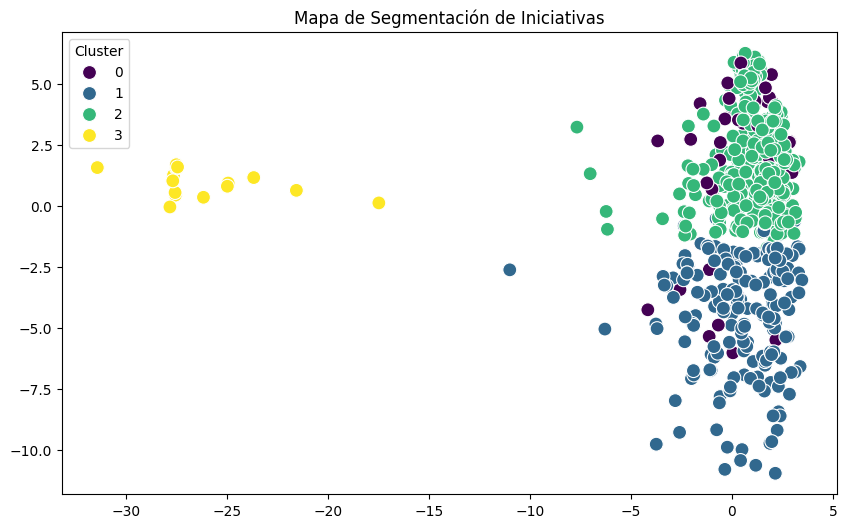

In [8]:
# Visualización PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='viridis', s=100)
plt.title('Mapa de Segmentación de Iniciativas')
plt.show()